# Ideal Parameter Analysis ($\delta=2.5$, $\tau=1.25$, $\alpha=2$) ($\delta$ high)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.5
expected_tau = 1.25
expected_alpha = 2

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

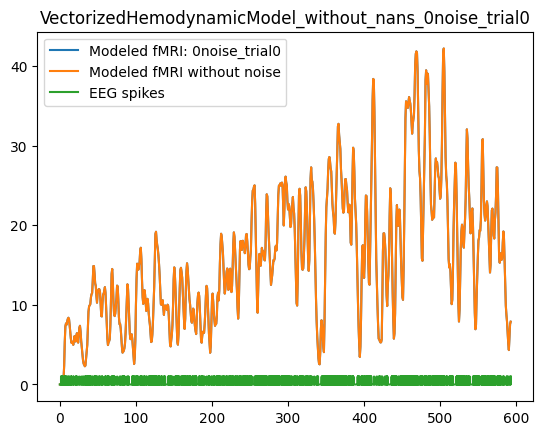

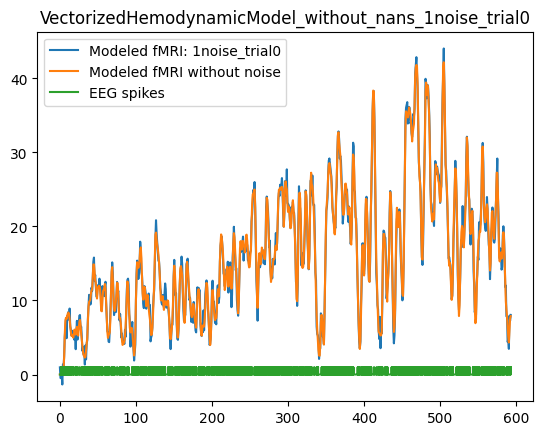

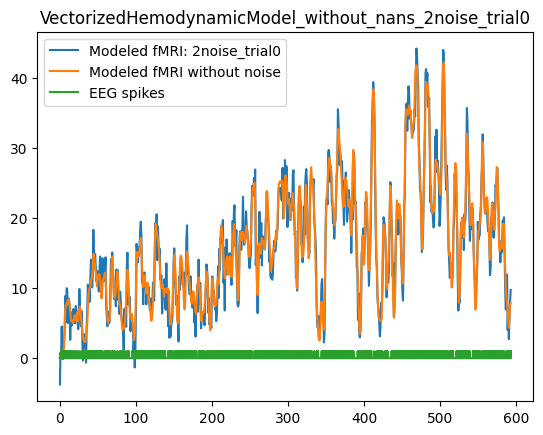

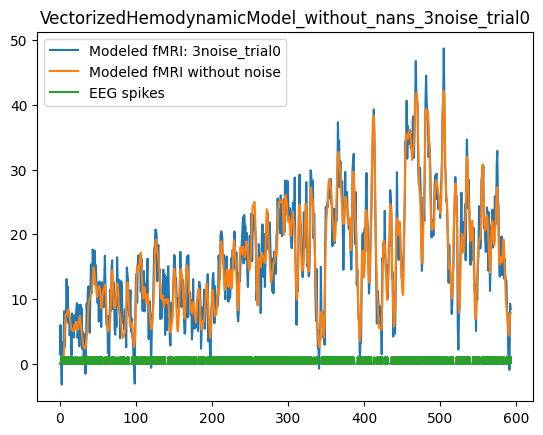

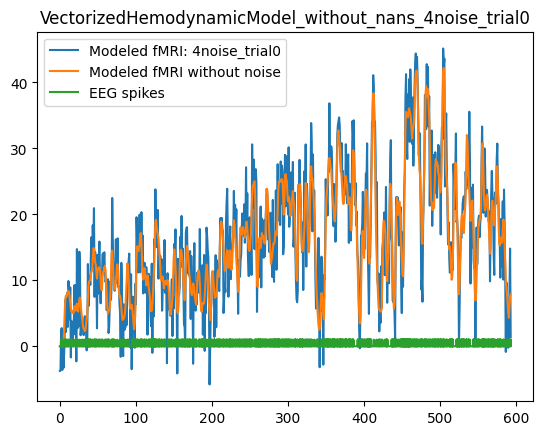

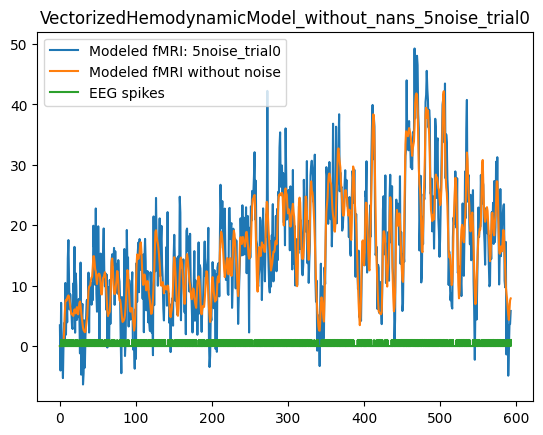

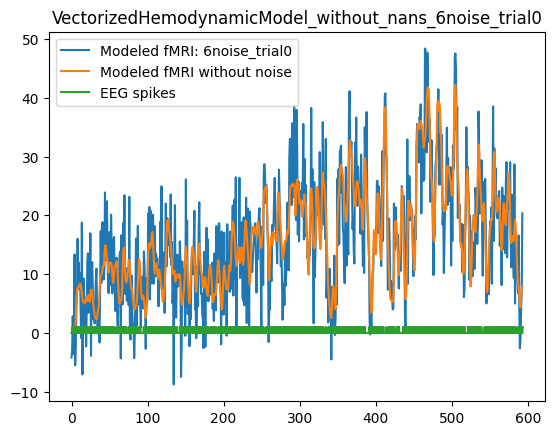

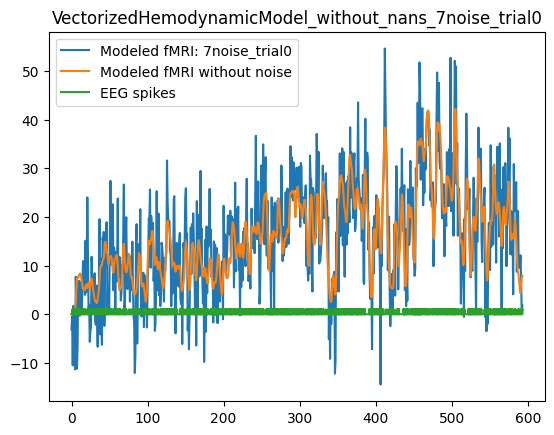

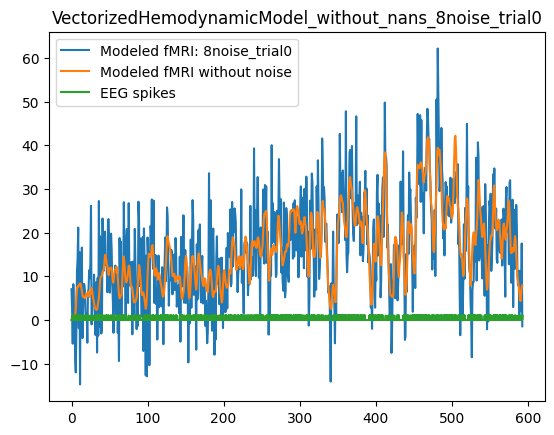

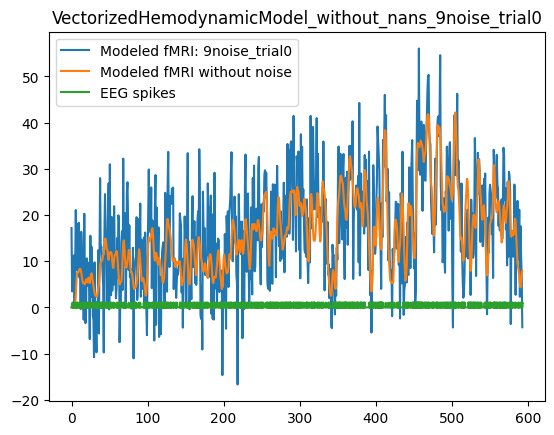

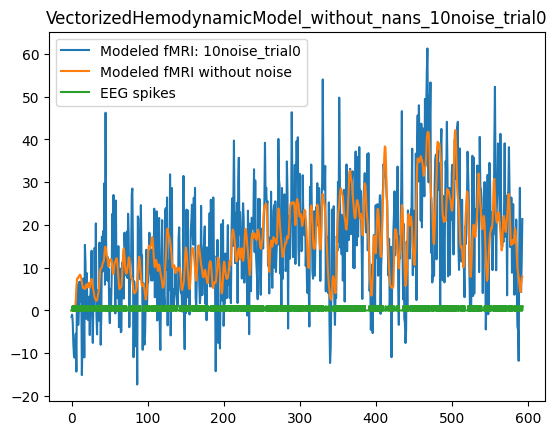

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.5, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 2, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.5, tau=1.25, alpha=2


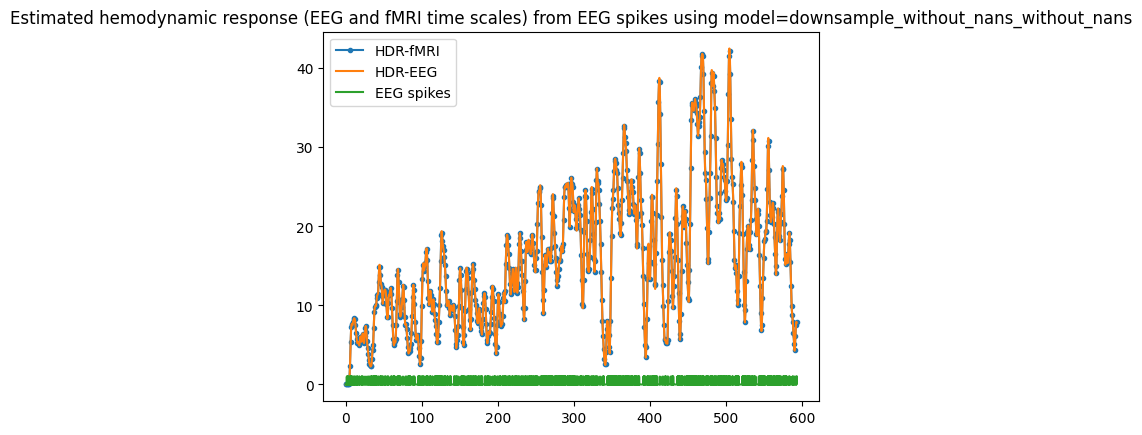

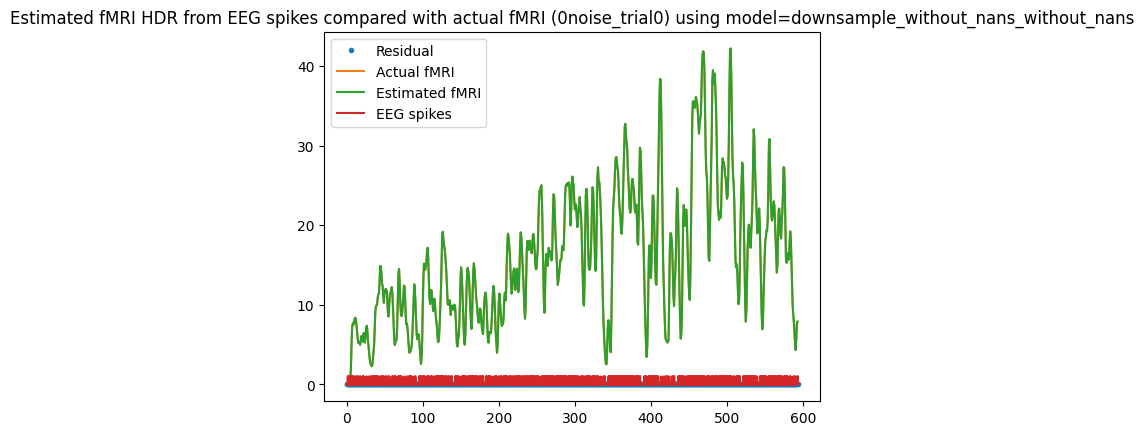

Residual Variance is 0.000000


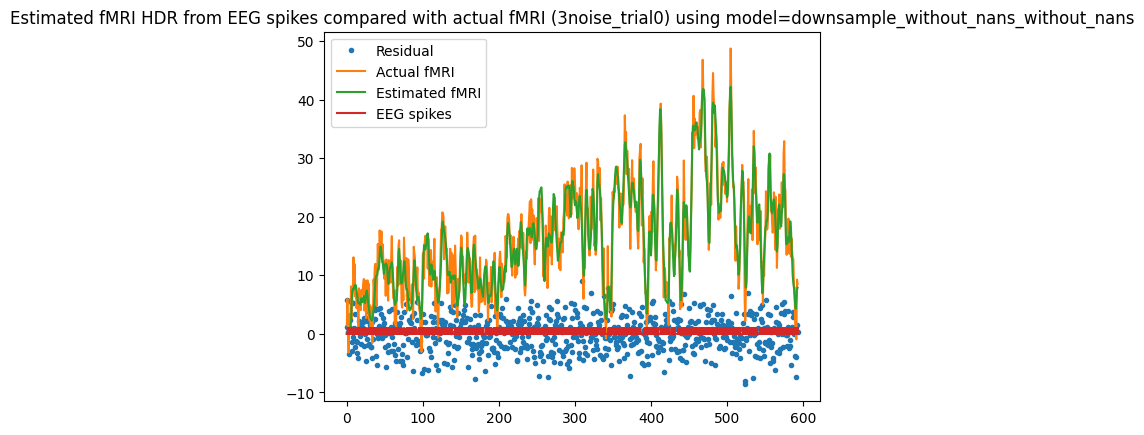

Residual Variance is 8.595960


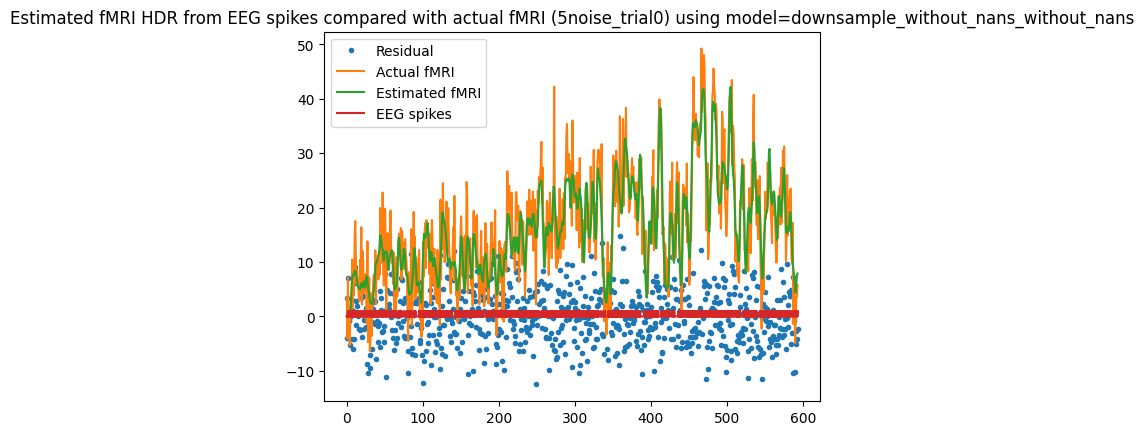

Residual Variance is 23.581185


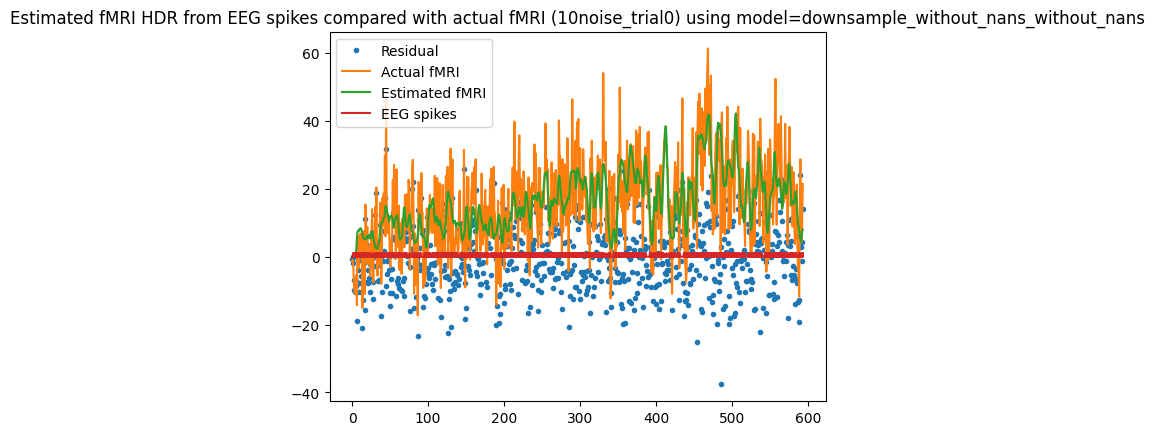

Residual Variance is 96.420090


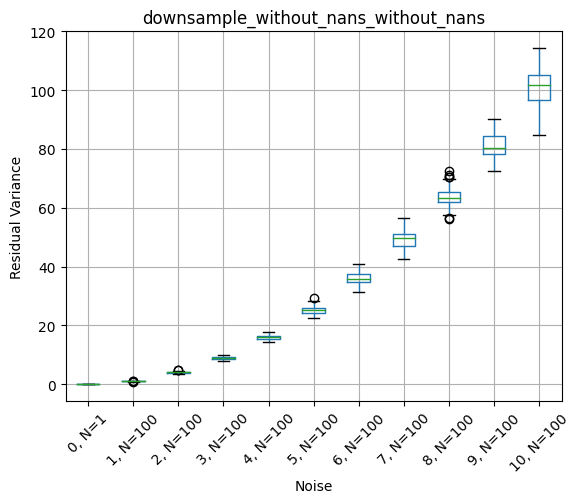

Scoring downsample_without_nans_with_nans delta=2.5, tau=1.25, alpha=2


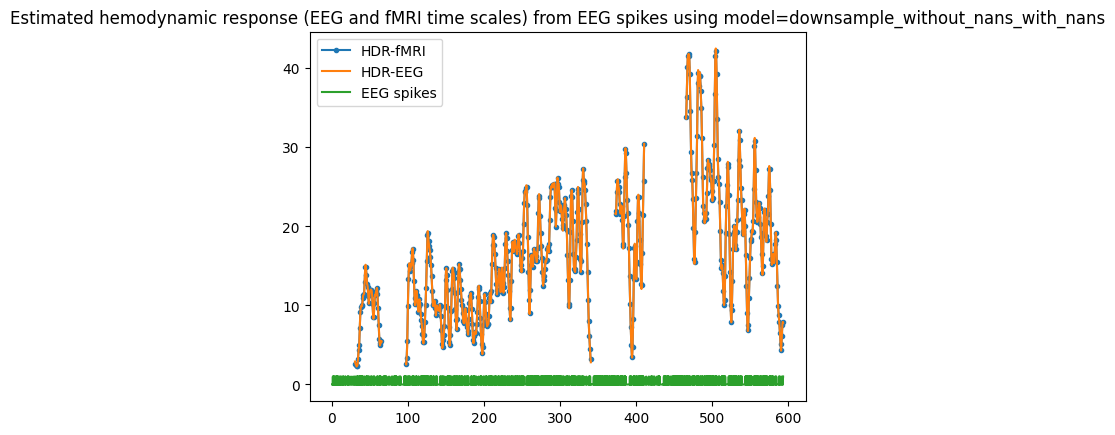

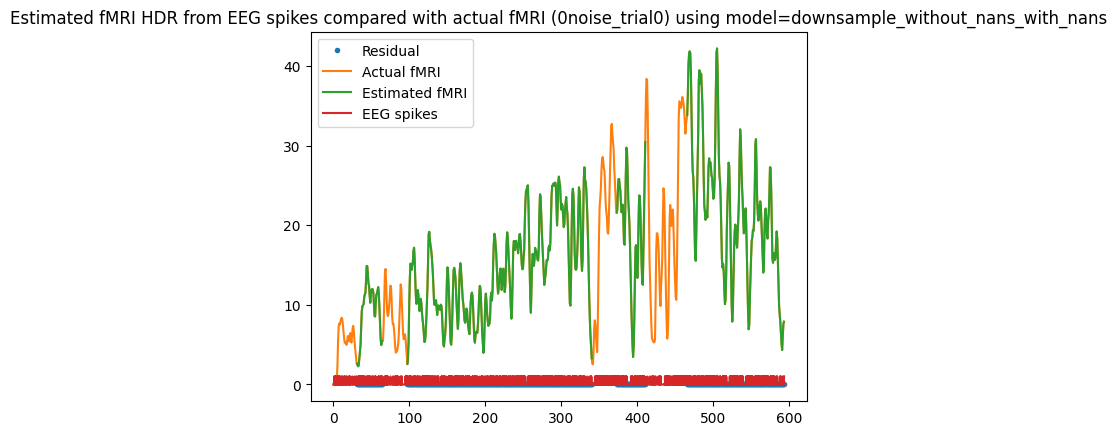

Residual Variance is 0.000000


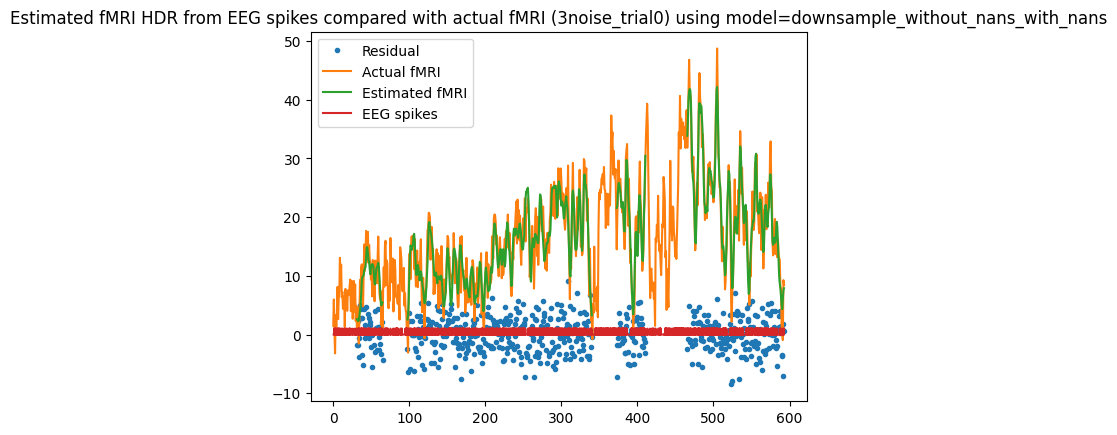

Residual Variance is 8.667295


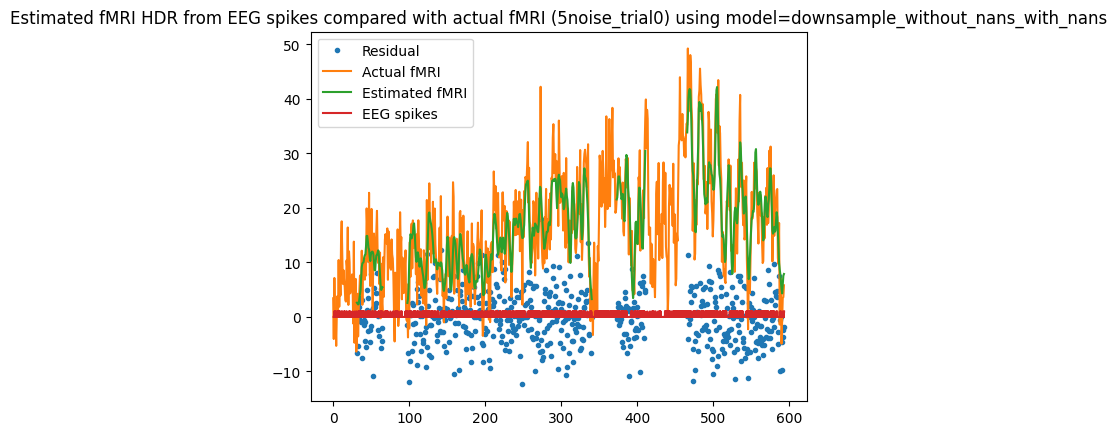

Residual Variance is 23.906460


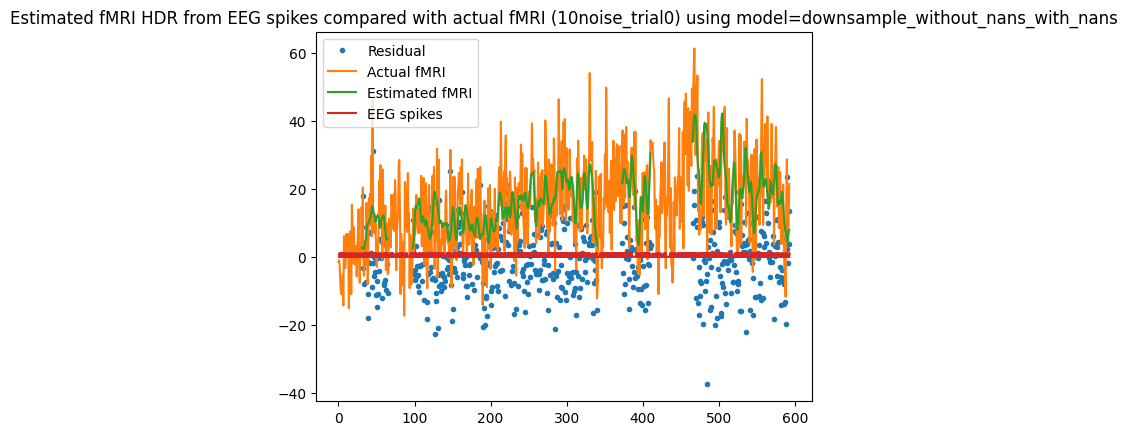

Residual Variance is 96.702090


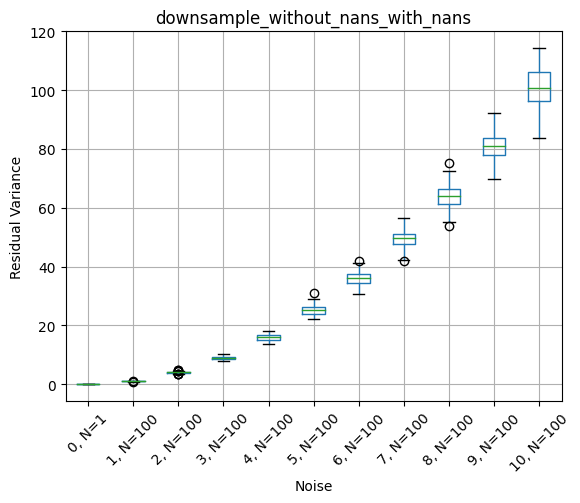

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans   46.93593208990055   
1         downsample_without_nans_with_nans  42.574492928096035   
2      downsample_without_nans_without_nans  46.173487450819735   
3         downsample_without_nans_with_nans  41.938812372306025   
4      downsample_without_nans_without_nans  45.399802371736776   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans  11.190833248025793   
18938  downsample_without_nans_without_nans  13.054067058465126   
18939     downsample_without_nans_with_nans  11.881245861928445   
18940  downsample_without_nans_without_nans  13.831840064100875   
18941     downsample_without_nans_with_nans  12.570133160226604   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0      48.356198168294185   51.22174060961055   55.42551969454529   
1      43.825565222526734   47.24305949040547   52.87157970813031   
2       47.58331554654418   50.44648360529926   54.67853243400639   
3       43.18274800718102   46.58191782750418   52.22138513846575   
4       46.79894072167654   49.65956311100821  53.919149339077165   
...                   ...                 ...                 ...   
18937  12.049002266470605   16.06107373301277  20.865911456348734   
18938  13.980070050290527  17.438752450048273   22.25024649484379   
18939   12.73589671288757  16.776017997528772  21.602238154349394   
18940  14.762077168116205  18.232338510457566    23.0455435151757   
18941    13.4212547105915  17.488771780144248  22.336427172564793   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0       68.54616266349032   71.23020154776479  ...   47.32185843064351   
1       62.77091071505306   69.27984900081935  ...   42.80906838407352   
2        67.7272510907208   70.44190912187413  ...   46.56922203093679   
3      62.068765322234064   68.57895309925489  ...   42.17740303166371   
4       66.89404665016028   69.64249246383002  ...   45.80562513338775   
...                   ...                 ...  ...                 ...   
18937   30.41165344592479  36.128356176386546  ...  11.863082217683184   
18938   31.01329183848402   37.11681065298997  ...  13.693046143561904   
18939  31.127666340420436  36.901249981973855  ...  12.539430992177854   
18940  31.810456228368704  37.927682124899796  ...   14.45769887969653   
18941  31.840660129381565   37.67480290162638  ...   13.21460222996883   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0       50.40286787383421  55.638648013105204   63.21720927394683   
1       45.80471475454411   50.50201271223527  57.926618426981435   
2       49.65943114203909  54.902828869863065   62.36697005329585   
3        45.1927542038843  49.886268249442075    57.2163586054118   
4       48.90469885889531   54.15572891978543   61.50548548317467   
...                   ...                 ...                 ...   
18937  15.015975631165919  18.683196727541485    27.5455406825498   
18938  17.154010986669057  20.618046222271605  30.756868446089463   
18939  15.679926748801163  19.359762565390955  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 4.117668036577536e-28; at
       delta   tau  alpha
14090    2.5  1.25    2.0


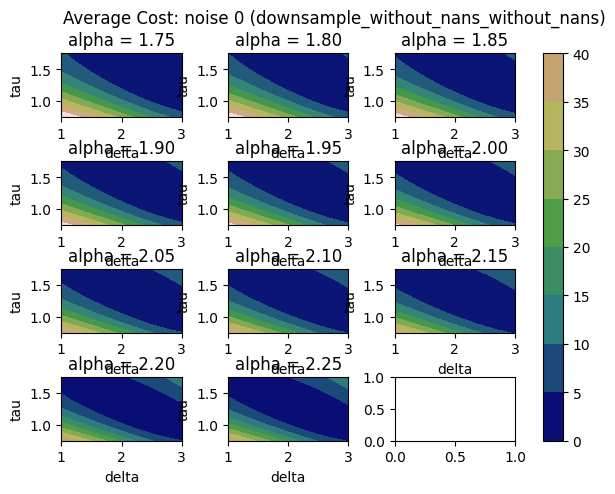

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              46.935932             
2                                              46.173487             
4                                              45.399802             
6                                              44.615358             
8                                              43.820664             
...                                                  ...             
18932                                          10.734885             
18934                                          11.503888             
18936                                          12.277536             
18938                                          13.054067             
18940                                          13.831840             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.5, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0    2.5  1.25    2.0

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.5, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.298093e-03   2.45  1.20   2.15
1      0         0  4.117668e-28   2.50  1.25   2.00
2      0         0  5.305106e-03   2.55  1.30   1.85

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 2.7173333836119367e-28; at
       delta   tau  alpha
14091    2.5  1.25    2.0


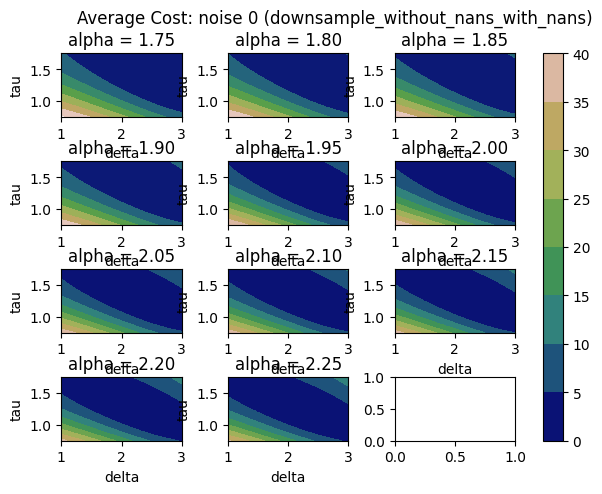

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              42.574493          
3                                              41.938812          
5                                              41.290886          
7                                              40.631053          
9                                              39.959687          
...                                                  ...          
18933                                           9.811673          
18935                                          10.500424          
18937                                          11.190833          
18939                                          11.881246          
18941                                          12.570133          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.5, Tau target: 1.25, Alpha target: 2


delta   tau  alpha
0    2.5  1.25    2.0

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.5, Tau target: 1.25, Alpha target: 2


noise iteration          cost  delta   tau  alpha
0      0         0  3.205903e-03   2.45  1.20   2.15
1      0         0  2.717333e-28   2.50  1.25   2.00
2      0         0  5.279038e-03   2.55  1.30   1.85

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.9906326600435684; at
       delta   tau  alpha
14090    2.5  1.25    2.0


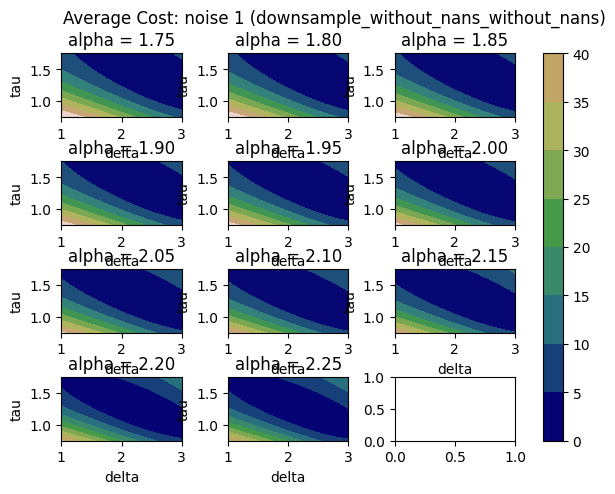

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.018815081443922; at
       delta   tau  alpha
14090    2.5  1.25    2.0


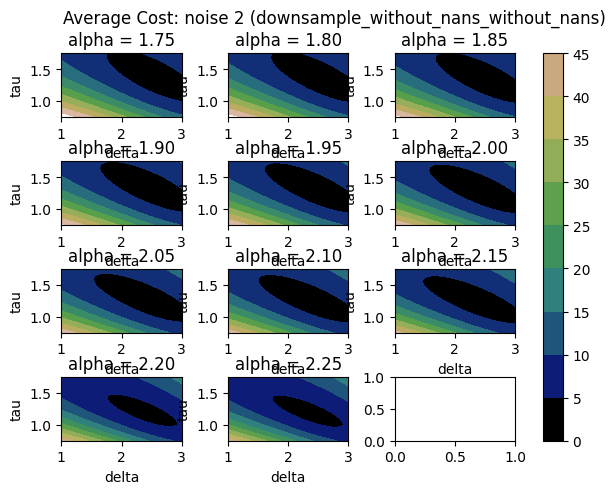

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 8.971701117430673; at
       delta   tau  alpha
14090    2.5  1.25    2.0


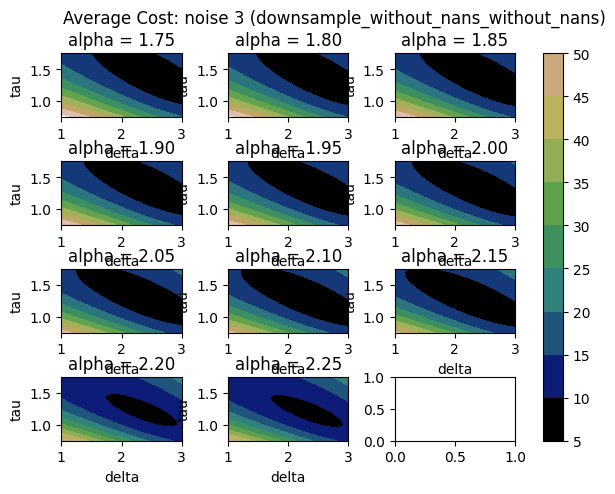

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 15.978929070311887; at
       delta   tau  alpha
14090    2.5  1.25    2.0


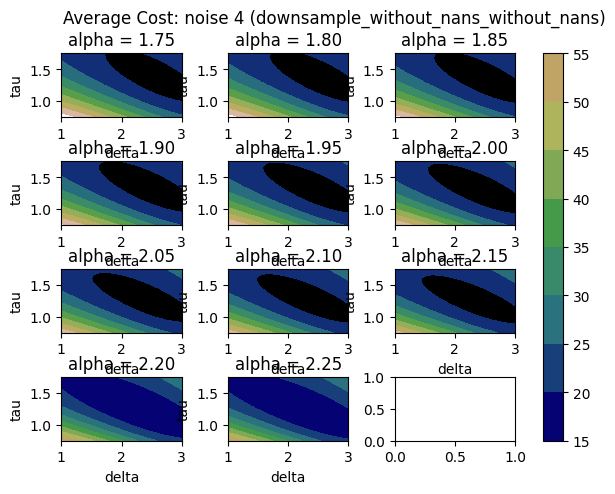

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 25.201814082979926; at
       delta   tau  alpha
14090    2.5  1.25    2.0


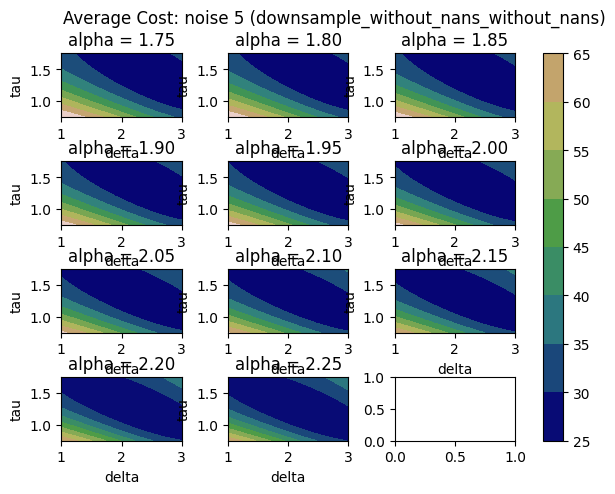

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 35.98179259046744; at
       delta   tau  alpha
14090    2.5  1.25    2.0


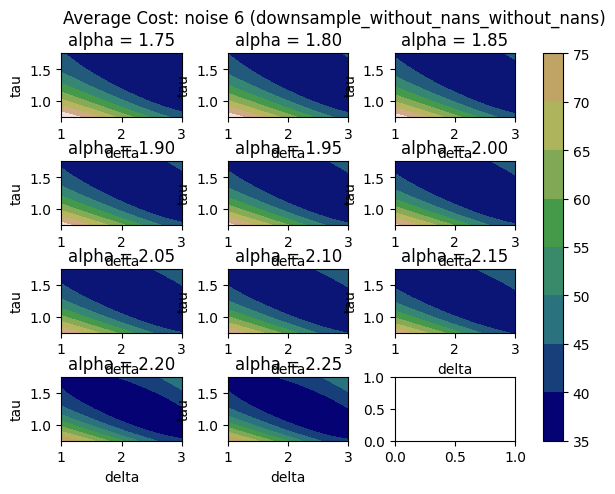

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 49.259291424539576; at
       delta   tau  alpha
14090    2.5  1.25    2.0


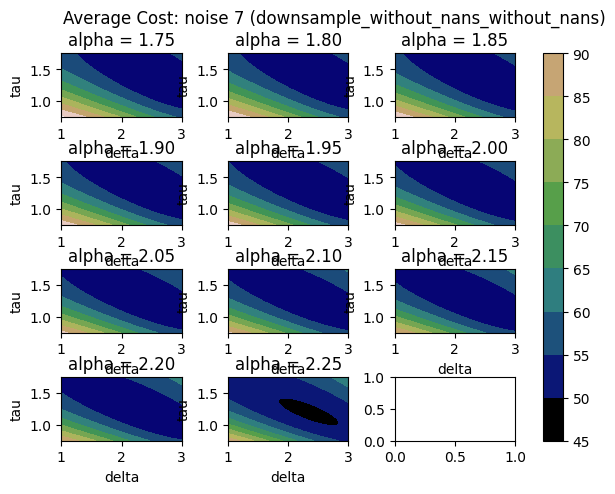

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 63.590196623271616; at
       delta   tau  alpha
13630   2.45  1.25   2.05


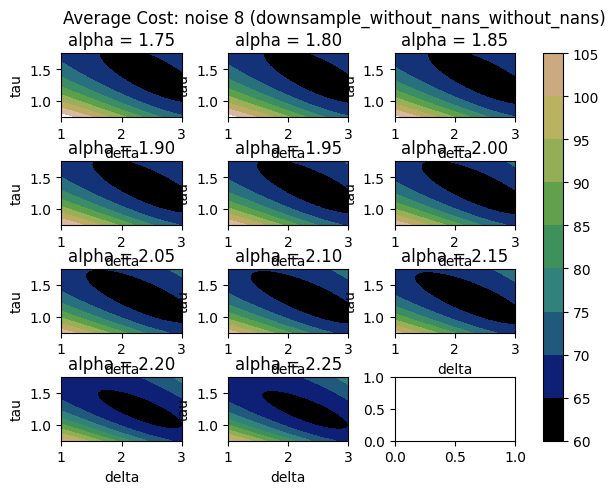

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 81.0276602162254; at
       delta   tau  alpha
14090    2.5  1.25    2.0


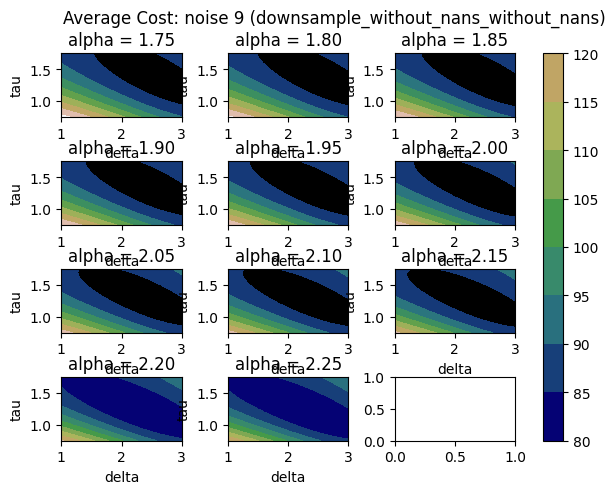

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 101.04195156805223; at
       delta   tau  alpha
14090    2.5  1.25    2.0


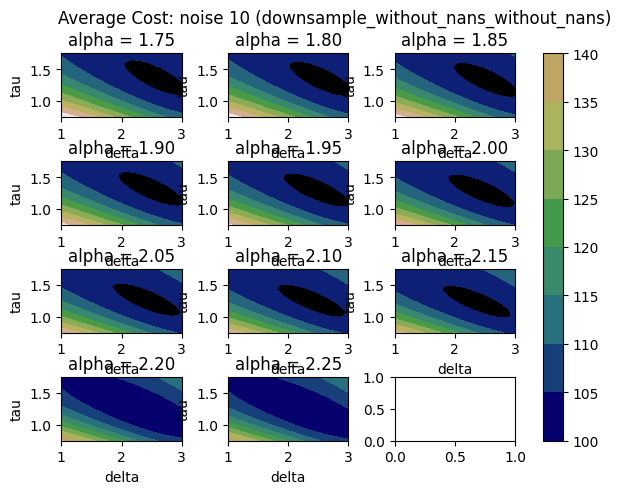

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

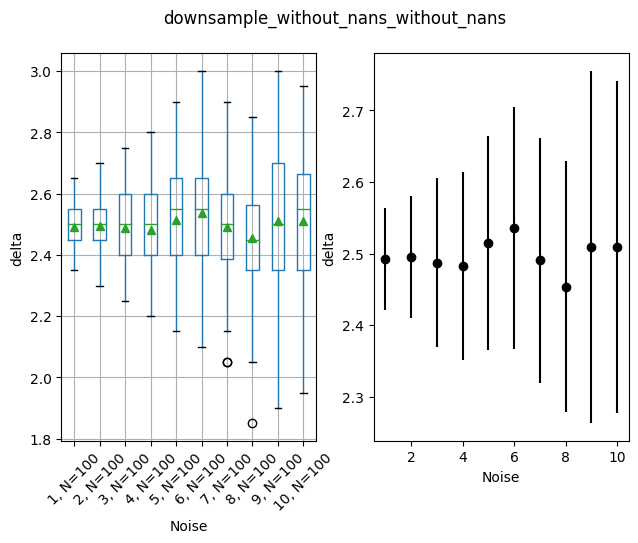

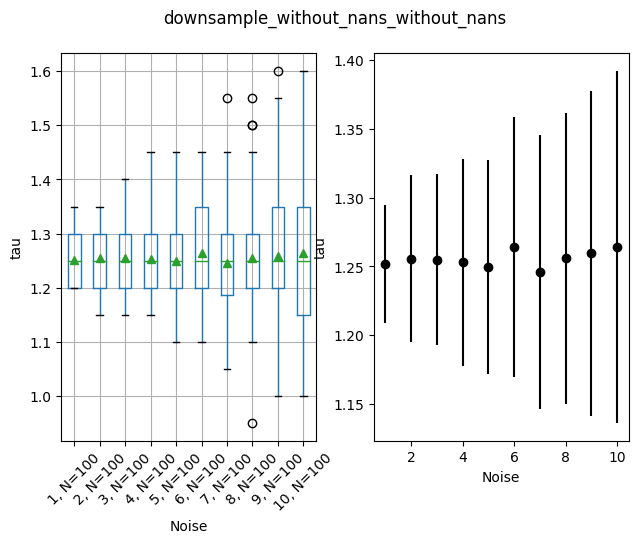

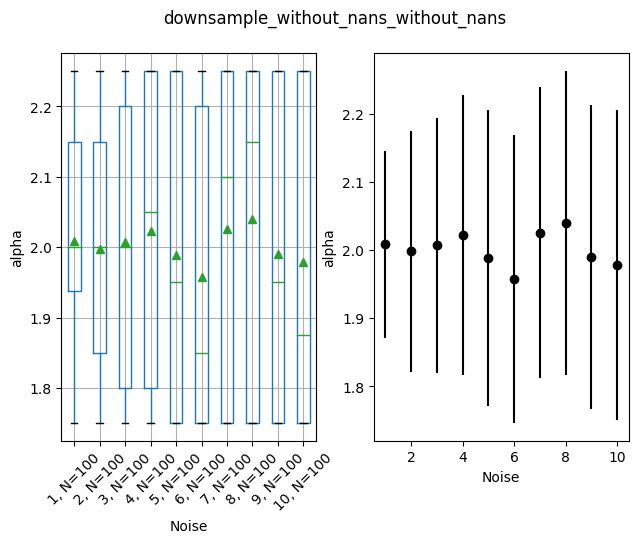

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 0.9917692209219945; at
       delta   tau  alpha
14091    2.5  1.25    2.0


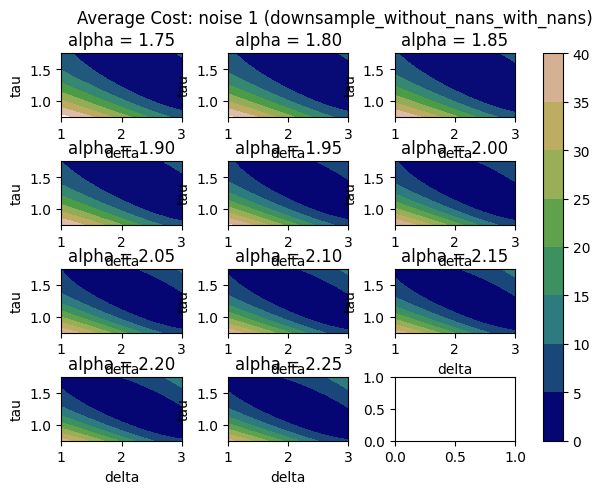

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.019226470593792; at
       delta   tau  alpha
14091    2.5  1.25    2.0


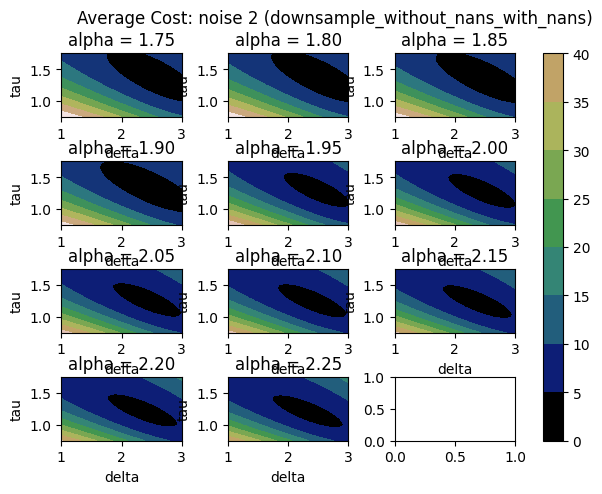

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 8.89484986036488; at
       delta   tau  alpha
14091    2.5  1.25    2.0


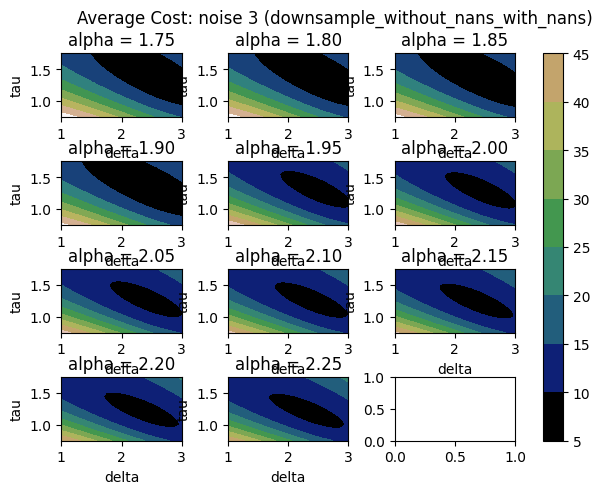

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 15.91175640517439; at
       delta   tau  alpha
14091    2.5  1.25    2.0


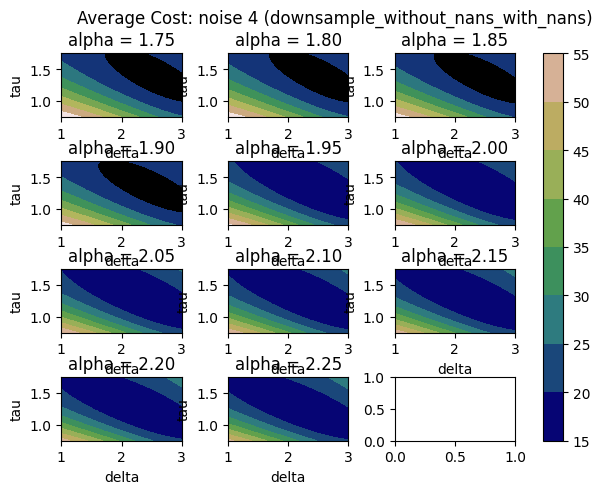

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.14247711290915; at
       delta   tau  alpha
14091    2.5  1.25    2.0


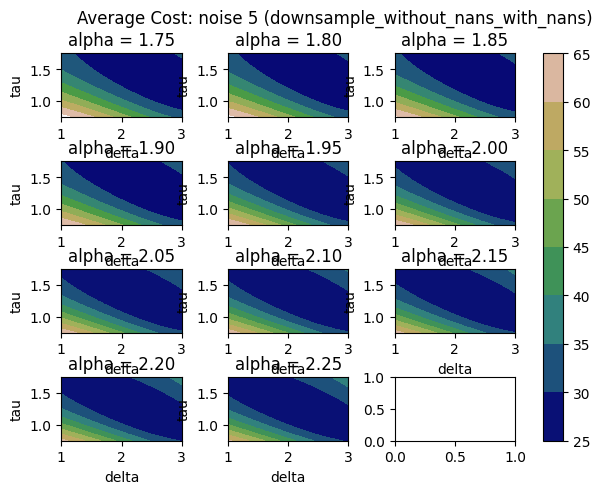

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 36.050873437266944; at
       delta   tau  alpha
14091    2.5  1.25    2.0


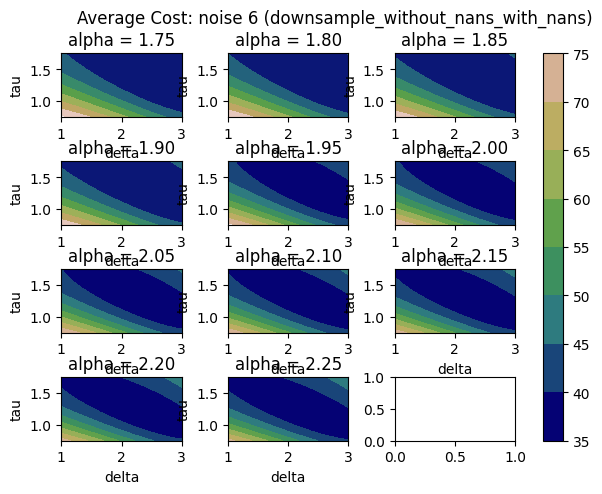

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 49.25892644184779; at
       delta   tau  alpha
14091    2.5  1.25    2.0


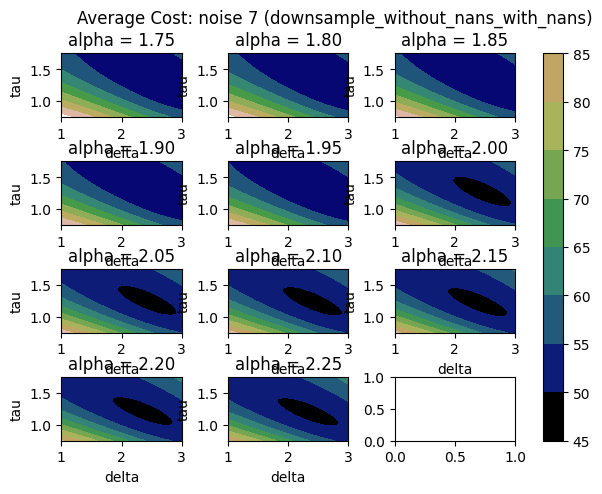

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 63.950293525152745; at
       delta  tau  alpha
13153    2.4  1.2    2.2


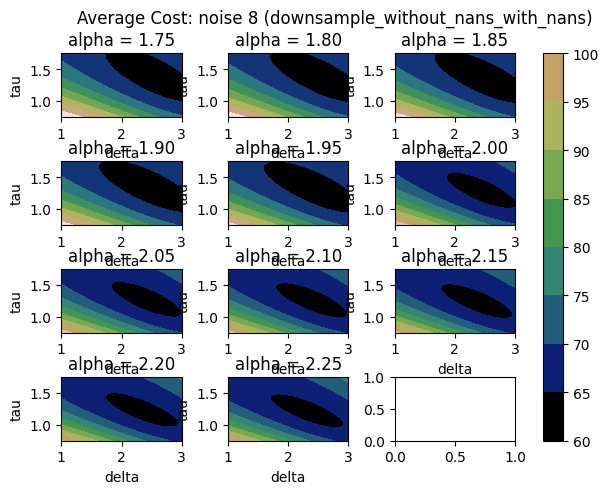

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 80.85924754849304; at
       delta   tau  alpha
13631   2.45  1.25   2.05


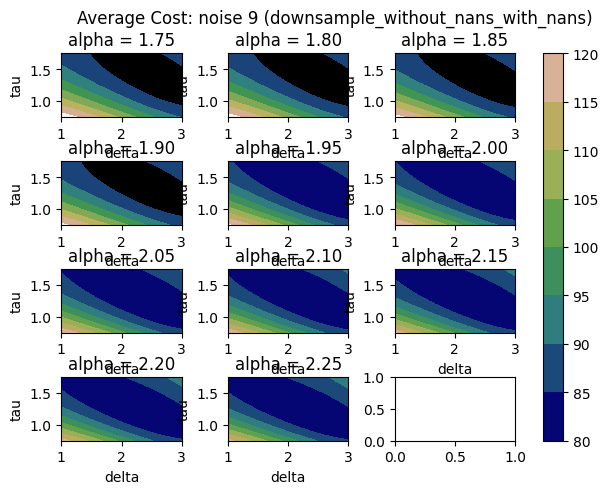

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 100.65749212747583; at
       delta  tau  alpha
14569   2.55  1.3   1.85


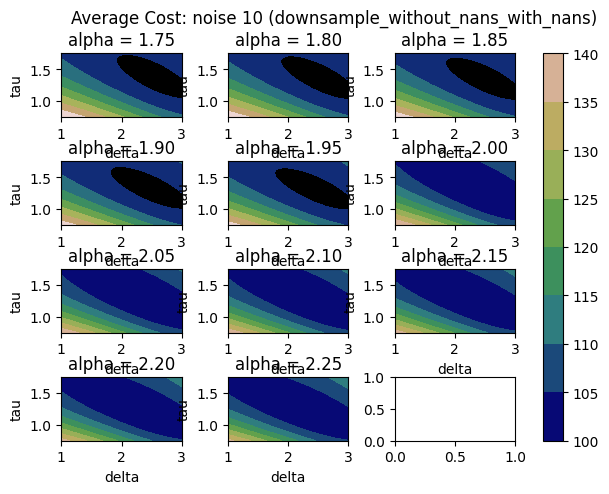

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


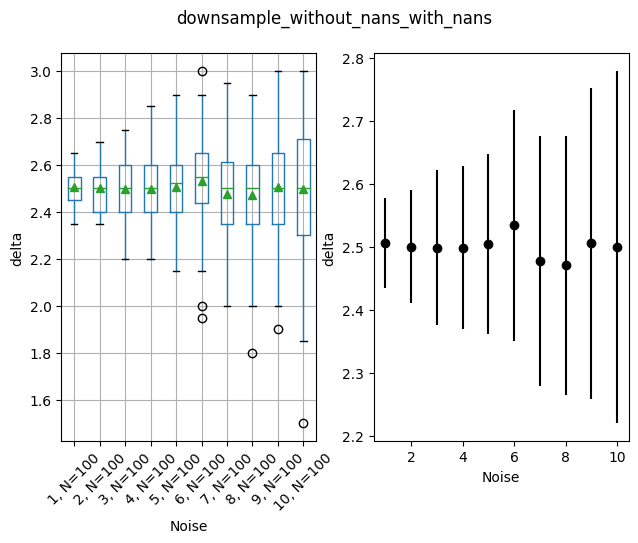

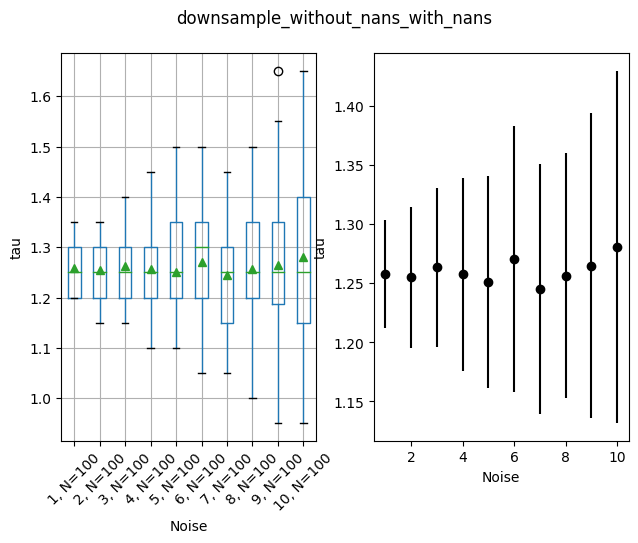

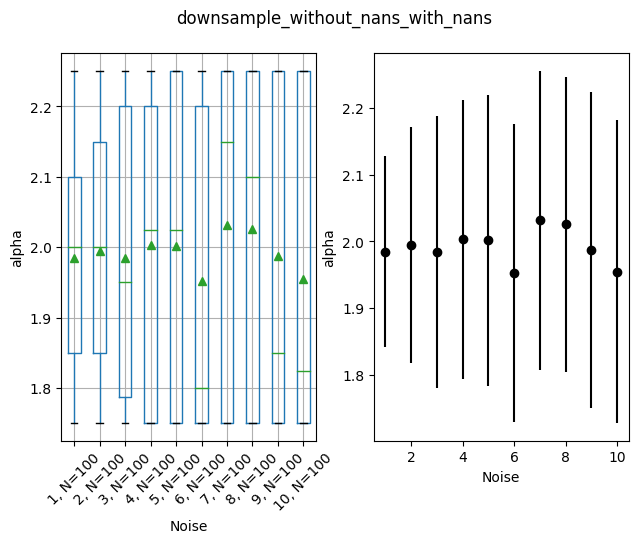

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1         2    0.949365  2.3500000000000014  1.2000000000000004   
1         1        34    0.992489  2.3500000000000014  1.2000000000000004   
2         1        36    1.064048  2.3500000000000014  1.2000000000000004   
3         1        88    0.979368  2.3500000000000014  1.2000000000000004   
4         1        19    1.010773  2.3500000000000014  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2697     10        33   91.196604   2.950000000000002  1.1500000000000004   
2698     10        76  106.265087   2.950000000000002  1.1500000000000004   
2699     10        34   98.799225   2.950000000000002  1.1500000000000004   
2700     10        43   89.958698  3.0000000000000018  1.1500000000000004   
2701     10        34   98.819032  3.0000000000000018  1.2000000000000004   

                   alpha  
0                    2.2  
1                    2.2  
2                    2.2  
3                    2.2  
4     2.2500000000000004  
...                  ...  
2697                1.75  
2698                1.75  
2699  1.9500000000000002  
2700                1.75  
2701                 1.8  

[2702 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.42  0.571724  2.0  3.0  3.0  4.0  4.0
2                      100.0  3.43  0.623691  1.0  3.0  3.0  4.0  4.0
3                      100.0  3.30  0.893297  1.0  3.0  4.0  4.0  4.0
4                      100.0  2.89  1.062634  1.0  2.0  3.0  4.0  4.0
5                      100.0  2.65  1.057680  1.0  2.0  3.0  3.0  4.0
6                      100.0  2.33  1.119659  1.0  1.0  2.5  3.0  4.0
7                      100.0  2.52  1.150143  1.0  1.0  3.0  3.0  5.0
8                      100.0  2.19  1.134358  1.0  1.0  2.0  3.0  4.0
9                      100.0  2.13  1.177697  1.0  1.0  2.0  3.0  5.0
10                     100.0  2.16  1.212061  1.0  1.0  2.0  3.0  5.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration       cost               delta                 tau  \
1801      6         7  36.057067  3.0000000000000018  1.3000000000000005   
2484      9        22  82.770213  3.0000000000000018  1.0500000000000003   
2485      9        22  82.766264  3.0000000000000018  1.1000000000000003   
2700     10        43  89.958698  3.0000000000000018  1.1500000000000004   
2701     10        34  98.819032  3.0000000000000018  1.2000000000000004   

                   alpha  
1801                1.75  
2484  2.1500000000000004  
2485  2.0500000000000003  
2700                1.75  
2701                 1.8

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
271       1        88    0.980109  2.5500000000000016  1.3500000000000005   
299       1         0    0.857613  2.6000000000000014  1.3500000000000005   
300       1         2    0.951481  2.6000000000000014  1.3500000000000005   
301       1         7    1.006790  2.6000000000000014  1.3500000000000005   
302       1        12    1.013905  2.6000000000000014  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2695     10        29  110.266999  2.9000000000000017  1.3000000000000005   
2696     10        20  109.230556   2.950000000000002  1.1500000000000004   
2697     10        33   91.196604   2.950000000000002  1.1500000000000004   
2698     10        76  106.265087   2.950000000000002  1.1500000000000004   
2700     10        43   89.958698  3.0000000000000018  1.1500000000000004   

     alpha  
271   1.75  
299   1.75  
300   1.75  
301   1.75  
302   1.75  
...    ...  
2695  1.75  
2696  1.75  
2697  1.75  
2698  1.75  
2700  1.75  

[407 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        39      2  2.6000000000000014   38    39      1  1.3500000000000005   
10       50     14  2.6000000000000014    7    50     10  1.2500000000000004   
2        38      4  2.6000000000000014   20    38      2  1.3500000000000005   
3        42      6  2.6500000000000012   18    42      3  1.3500000000000005   
4        37      8  2.5500000000000016    8    37      5  1.3500000000000005   
5        41      7  2.6500000000000012   11    41      5  1.3000000000000005   
6        48     11  2.5500000000000016    8    48      7  1.3500000000000005   
7        39     12  2.5500000000000016    7    39      7  1.3500000000000005   
8        31     11  2.5500000000000016    6    31      8  1.3500000000000005   
9        42     15  2.7000000000000015    6    42     11  1.3500000000000005   

            
      freq  
noise       
1       39  
10       9  
2       30  
3       27  
4       17  
5       15  
6       13  
7       14  
8        8  
9       11

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
4         1        19    1.010773  2.3500000000000014  1.2000000000000004   
5         1        39    0.942621  2.3500000000000014  1.2000000000000004   
6         1        46    0.965439  2.3500000000000014  1.2000000000000004   
7         1        65    0.973161  2.3500000000000014  1.2000000000000004   
8         1        73    0.943365  2.3500000000000014  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2650     10        74  104.915766  2.7000000000000015  1.0500000000000003   
2664     10        43   89.890569  2.7500000000000018  1.0500000000000003   
2665     10        77  105.186727  2.7500000000000018  1.0500000000000003   
2684     10        43   89.890091  2.8500000000000014  1.0000000000000002   
2692     10        77  105.221659  2.9000000000000017  1.0000000000000002   

                   alpha  
4     2.2500000000000004  
5     2.2500000000000004  
6     2.2500000000000004  
7     2.2500000000000004  
8     2.2500000000000004  
...                  ...  
2650  2.2500000000000004  
2664  2.2500000000000004  
2665  2.2500000000000004  
2684  2.2500000000000004  
2692  2.2500000000000004  

[415 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        13      3  2.3500000000000014    8    13      2  1.2000000000000004   
10       49     19   2.300000000000001    6    49      9  1.2500000000000004   
2        37      5  2.3500000000000014   15    37      2  1.2000000000000004   
3        46      6  2.3500000000000014   11    46      3  1.2000000000000004   
4        48      8  2.3500000000000014   13    48      4  1.2000000000000004   
5        37     10  2.4000000000000012   11    37      5  1.2000000000000004   
6        38     13  2.4000000000000012    8    38      5  1.2000000000000004   
7        50     13   2.300000000000001    7    50      7  1.2000000000000004   
8        51     13   2.250000000000001   10    51      9  1.2000000000000004   
9        46     20  2.4000000000000012    6    46      9  1.2500000000000004   

            
      freq  
noise       
1        8  
10       9  
2       19  
3       23  
4       26  
5       16  
6       13  
7       17  
8       16  
9       12

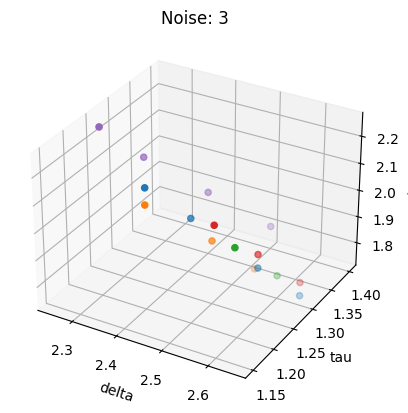

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

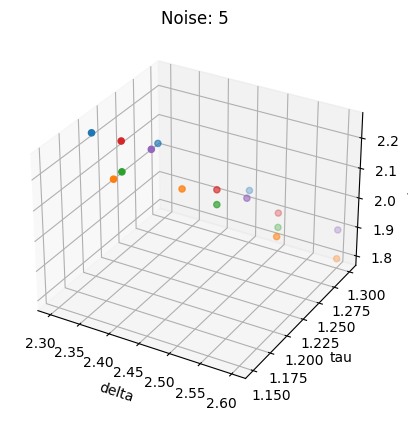

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

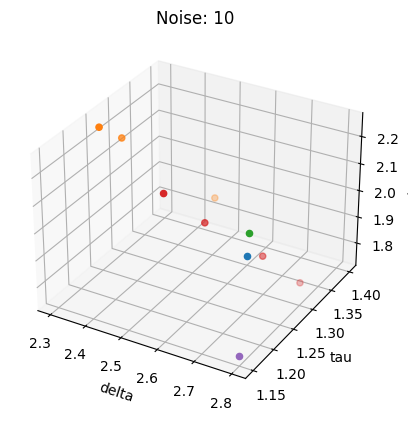

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        36    1.092063  2.3500000000000014  1.2000000000000004   
1         1        88    0.951788  2.3500000000000014  1.2000000000000004   
2         1        19    1.070066  2.3500000000000014  1.2000000000000004   
3         1        39    0.974421  2.3500000000000014  1.2000000000000004   
4         1        46    0.990446  2.3500000000000014  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2532     10        59   91.066988  3.0000000000000018  1.0500000000000003   
2533     10        94  107.309181  3.0000000000000018  1.0500000000000003   
2534     10        94  107.323584  3.0000000000000018  1.1000000000000003   
2535     10        61  107.137232  3.0000000000000018  1.1000000000000003   
2536     10        61  107.135281  3.0000000000000018  1.1500000000000004   

                   alpha  
0                    2.2  
1                    2.2  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
...                  ...  
2532                1.85  
2533  1.9000000000000001  
2534                 1.8  
2535                1.85  
2536                1.75  

[2537 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                          
                       count  mean       std  min  25%  50%   75%  max
noise                                                                 
1                      100.0  3.48  0.577000  2.0  3.0  4.0  4.00  4.0
2                      100.0  3.30  0.643538  1.0  3.0  3.0  4.00  4.0
3                      100.0  3.19  0.860995  1.0  3.0  3.0  4.00  4.0
4                      100.0  2.53  1.141105  1.0  1.0  3.0  3.25  4.0
5                      100.0  2.45  1.192358  1.0  1.0  3.0  4.00  4.0
6                      100.0  2.14  1.091936  1.0  1.0  2.0  3.00  4.0
7                      100.0  2.26  1.168786  1.0  1.0  2.0  3.00  5.0
8                      100.0  1.98  1.082272  1.0  1.0  2.0  3.00  4.0
9                      100.0  1.85  1.131505  1.0  1.0  1.0  3.00  5.0
10                     100.0  2.19  1.244747  1.0  1.0  2.0  3.00  5.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration        cost               delta                 tau  \
1708      6         7   37.849215  3.0000000000000018  1.2500000000000004   
2314      9        20   78.563094  3.0000000000000018  1.1000000000000003   
2315      9        22   83.881758  3.0000000000000018  1.2500000000000004   
2316      9         1   80.205562  3.0000000000000018  1.3000000000000005   
2317      9         7   76.874499  3.0000000000000018  1.3000000000000005   
2532     10        59   91.066988  3.0000000000000018  1.0500000000000003   
2533     10        94  107.309181  3.0000000000000018  1.0500000000000003   
2534     10        94  107.323584  3.0000000000000018  1.1000000000000003   
2535     10        61  107.137232  3.0000000000000018  1.1000000000000003   
2536     10        61  107.135281  3.0000000000000018  1.1500000000000004   

                   alpha  
1708                 1.8  
2314  2.2500000000000004  
2315                1.75  
2316                1.75  
2317                1.75  
2532                1.85  
2533  1.9000000000000001  
2534                 1.8  
2535                1.85  
2536                1.75

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
267       1        88    0.937535  2.5500000000000016  1.3500000000000005   
299       1         0    0.884543  2.6000000000000014  1.3500000000000005   
300       1         1    0.977905  2.6000000000000014  1.3500000000000005   
301       1         2    0.892194  2.6000000000000014  1.3500000000000005   
302       1         7    0.981744  2.6000000000000014  1.3500000000000005   
...     ...       ...         ...                 ...                 ...   
2527     10        33   90.577817  2.9000000000000017  1.1500000000000004   
2528     10        62   96.367919  2.9000000000000017  1.2000000000000004   
2529     10        37   89.450182  2.9000000000000017  1.2500000000000004   
2531     10        76  110.603898   2.950000000000002  1.1500000000000004   
2536     10        61  107.135281  3.0000000000000018  1.1500000000000004   

     alpha  
267   1.75  
299   1.75  
300   1.75  
301   1.75  
302   1.75  
...    ...  
2527  1.75  
2528  1.75  
2529  1.75  
2531  1.75  
2536  1.75  

[433 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        45      3  2.6000000000000014   42    45      2  1.3500000000000005   
10       59     18  2.6000000000000014    7    59     12  1.3500000000000005   
2        31      4  2.6000000000000014   14    31      2  1.3500000000000005   
3        41      7  2.6000000000000014   15    41      4  1.3500000000000005   
4        39      8  2.6000000000000014   16    39      5  1.3500000000000005   
5        46     10  2.6000000000000014   11    46      7  1.3500000000000005   
6        48     12  2.5500000000000016   10    48      8  1.3500000000000005   
7        39     13  2.6500000000000012    8    39      7  1.3500000000000005   
8        38     12  2.5500000000000016    7    38      8  1.3000000000000005   
9        47     16  2.5000000000000013    8    47     11  1.3000000000000005   

            
      freq  
noise       
1       44  
10      10  
2       22  
3       24  
4       16  
5       16  
6       11  
7        9  
8        9  
9       14

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
2         1        19    1.070066  2.3500000000000014  1.2000000000000004   
3         1        39    0.974421  2.3500000000000014  1.2000000000000004   
4         1        46    0.990446  2.3500000000000014  1.2000000000000004   
5         1        50    1.033286  2.3500000000000014  1.2000000000000004   
6         1        76    1.030858  2.3500000000000014  1.2000000000000004   
...     ...       ...         ...                 ...                 ...   
2490     10        99   95.902043  2.7500000000000018  1.0500000000000003   
2505     10        34   95.850996  2.8000000000000016  1.1000000000000003   
2514     10        59   91.043809  2.8500000000000014  0.9500000000000002   
2516     10        61  107.172824  2.8500000000000014  1.0000000000000002   
2524     10        77  102.050598  2.9000000000000017  1.0000000000000002   

                   alpha  
2     2.2500000000000004  
3     2.2500000000000004  
4     2.2500000000000004  
5     2.2500000000000004  
6     2.2500000000000004  
...                  ...  
2490  2.2500000000000004  
2505  2.2500000000000004  
2514  2.2500000000000004  
2516  2.2500000000000004  
2524  2.2500000000000004  

[422 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        16      3  2.3500000000000014    9    16      2  1.2000000000000004   
10       47     26   2.250000000000001    4    47     11  1.2500000000000004   
2        39      5  2.3500000000000014   13    39      2  1.2000000000000004   
3        49      8  2.3500000000000014   12    49      3  1.2000000000000004   
4        40      9  2.4000000000000012    9    40      4  1.2000000000000004   
5        45      9  2.4000000000000012   10    45      6  1.2000000000000004   
6        36     12  2.3500000000000014    6    36      7  1.1500000000000004   
7        49     15   2.250000000000001    6    49      7  1.2000000000000004   
8        50     15  2.4000000000000012    8    50      9  1.2000000000000004   
9        51     20  2.4000000000000012    6    51      9  1.2500000000000004   

            
      freq  
noise       
1        9  
10      10  
2       22  
3       26  
4       17  
5       16  
6       12  
7       15  
8       12  
9       12

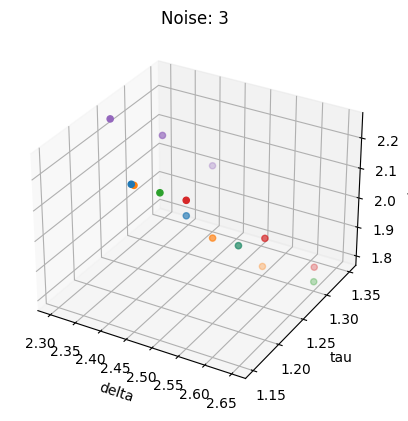

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

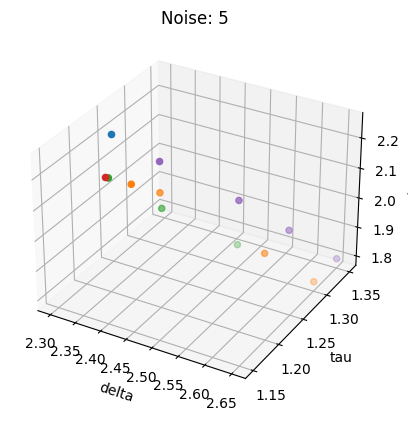

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

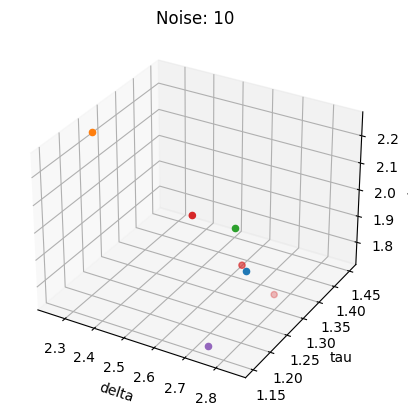

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()